## Import packages & Load data

In [70]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DEBUG_DATA = False

## Define Genetic Regression Class

In [92]:
class GeneticRegression():
    # Initialization
    # Randomly generate initial population
    def __init__(self, num_population, mutation_rate, train, test, stop_count):
        self.generation = 1
        self.n_pop = num_population
        self.mutation_rate = mutation_rate
        self.train = train
        self.test = test
        self.stop_count = stop_count
        self.alpha = np.array(['%+011.6f' % val for val in np.random.uniform(-1000+0.000001, 1000, self.n_pop)])
        self.bias = np.array(['%+011.6f' % val for val in np.random.uniform(-1000+0.000001, 1000, self.n_pop)])
        self.count = 1
        pass
    
    def fit(self):
        while self.count < self.stop_count:
            self.next_generation()
            x = np.linspace(-10, 110, 1000)
            plt.scatter(self.train['x'], self.train['y']);
            plt.plot(x, x*np.float(self.best_alpha)+np.float(self.best_bias), color='red');
            plt.title('loss: %8.4f'%self.min_loss+', alpha:'+self.best_alpha+', bias'+self.best_bias)
            plt.show();
            pass
        pass
    
    def debugging(self, index):
        for i, val_a, val_b in zip(index, self.alpha, self.bias):
            print('[element', '%2d]'%(i+1), 'alpha:', val_a, 'bias:', val_b)
            pass
        print('_'*50, '\n')
    
    def next_generation(self):
        print('Generation', '%2d'%self.generation, '_'*36,'\n')
        if DEBUG_DATA:
            self.debugging(range(self.n_pop))
        self.selection()
        self.crossover()
        self.mutation()
        self.get_loss()
        self.generation += 1
        pass
    
    # np.random.randint(a, b) => [a, b-1]
    # Selection
    def selection(self):
        if DEBUG_DATA: print('selection()', '_'*38,'\n')
        # Calculate the probability of selection for each element
        ratio = np.array([65535/self.MSE(self.query(i), self.train['y']) for i in range(self.n_pop)])
        # Calculate cumulative distribution
        ratio = np.cumsum(ratio/np.sum(ratio))
        # Select element for next generation
        next_idx = [np.min(np.where(ratio > val)) for val in np.random.uniform(0, 1, self.n_pop)]
        # Selected alpha value via random number
        next_alpha = self.alpha[next_idx]
        # Selected bias value via random number
        next_bias = self.bias[next_idx]
        self.alpha = next_alpha
        self.bias = next_bias
        if DEBUG_DATA:
            print('Selected elements\n')
            self.debugging(next_idx)
        pass
    
    # Crossover
    def crossover(self):
        if DEBUG_DATA: print('crossover()', '_'*38,'\n')
        n = self.n_pop
        # Crossover one gene and another
        for i, j in zip(list(range(math.ceil(n/2+0.1)-1)), list(range(n-1, math.ceil(n/2)-1, -1))):
            if DEBUG_DATA: print('Recombinate element', i+1, 'and element',j+1)
            a1 = '%04d' % (np.int(self.alpha[i][:4]) + 1000)
            a2 = '%04d' % (np.int(self.alpha[j][:4]) + 1000)
            b1 = '%04d' % (np.int(self.bias[i][:4]) + 1000)
            b2 = '%04d' % (np.int(self.bias[j][:4]) + 1000)
            self.alpha[i] = '%+04d'%(np.int(a1[:2] + a2[2:]) - 1000) + self.alpha[i][4:]
            self.alpha[j] = '%+04d'%(np.int(a2[:2] + a1[2:]) - 1000) + self.alpha[j][4:]
            self.bias[i] = '%+04d'%(np.int(b1[:2] + b2[2:]) - 1000) + self.bias[i][4:]
            self.bias[j] = '%+04d'%(np.int(b2[:2] + b1[2:]) - 1000) + self.bias[j][4:]
            pass
        if DEBUG_DATA:
            print('\nrecombined elements', '\n')
            self.debugging(range(self.n_pop))
        pass
    
    # Mutation
    def mutation(self):
        if DEBUG_DATA: print('mutation()', '_'*39,'\n')
        n = self.n_pop
        for i in range(n):
            alpha_genes = np.array([int(gene) for gene in self.alpha[i][1:4] + self.alpha[i][5:]])
            alpha_mutate = np.random.uniform(-1, 1, 9)
            alpha_genes[alpha_mutate > 1 - self.mutation_rate] += 1
            alpha_genes[alpha_genes > 9] = 9
            alpha_genes[alpha_mutate < -1 + self.mutation_rate] -= 1
            alpha_genes[alpha_genes < 0] = 0
            
            bias_genes = np.array([int(gene) for gene in self.bias[i][1:4] + self.bias[i][5:]])
            bias_mutate = np.random.uniform(-1, 1, 9)
            bias_genes[bias_mutate > 1 - self.mutation_rate] += 1
            bias_genes[bias_genes > 9] = 9
            bias_genes[bias_mutate < -1 + self.mutation_rate] -= 1
            bias_genes[bias_genes < 0] = 0
            
            self.alpha[i] = self.alpha[i][0]
            for val in alpha_genes[:3]:
                self.alpha[i] += '%d'%val
                pass
            self.alpha[i] += '.'
            for val in alpha_genes[3:]:
                self.alpha[i] += '%d'%val
                
            self.bias[i] = self.bias[i][0]
            for val in bias_genes[:3]:
                self.bias[i] += '%d'%val
                pass
            self.bias[i] += '.'
            for val in bias_genes[3:]:
                self.bias[i] += '%d'%val
            pass
        
        if DEBUG_DATA:
            print('mutated elements', '\n')
            self.debugging(range(self.n_pop))
        pass
        
    def query(self, idx):
        return np.float(self.alpha[idx])*self.train['x']+np.float(self.bias[idx])

    # MSE
    def MSE(self, y, t):
        return np.sum((t-y)**2)/y.shape[0]
    
    def get_loss(self):
        if DEBUG_DATA: print('get_loss()', '_'*39,'\n')
        mse_all = [self.MSE(self.query(i), self.train['y']) for i in range(self.n_pop)]
        if DEBUG_DATA:
            for i, val_a, val_b, mse in zip(range(self.n_pop), self.alpha, self.bias, mse_all):
                print('[element', '%2d]'%(i+1), 'alpha:', val_a, 'bias:', val_b, ', Loss:', '%18.6f'%mse);
                pass
            pass
        minimum_loss = np.min(mse_all)
        index = mse_all.index(minimum_loss)
        if self.generation == 1:
            self.min_loss = minimum_loss
            self.best_alpha = self.alpha[index]
            self.best_bias = self.bias[index]
            self.count = 1
            pass
        else:
            if self.min_loss <= minimum_loss:
                self.count += 1
            else:
                self.min_loss = minimum_loss
                self.best_alpha = self.alpha[index]
                self.best_bias = self.bias[index]
                self.count = 1
            pass
        pass
    

> ## Genetic Regression #1
> Randomly created dataset for linear regression
> https://www.kaggle.com/andonians/random-linear-regression

Generation  1 ____________________________________ 



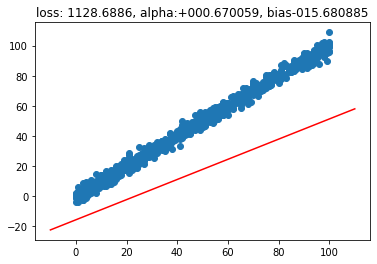

Generation  2 ____________________________________ 



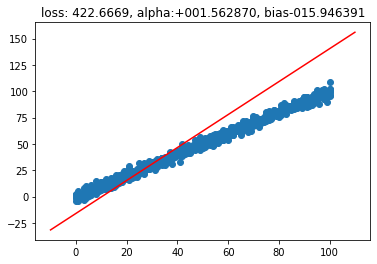

Generation  3 ____________________________________ 



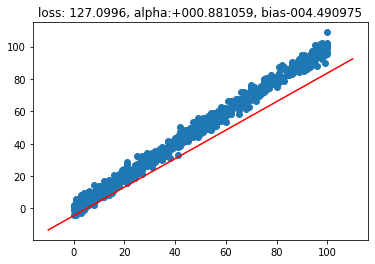

Generation  4 ____________________________________ 



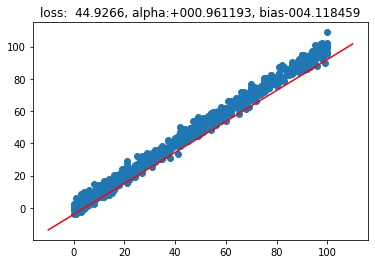

Generation  5 ____________________________________ 



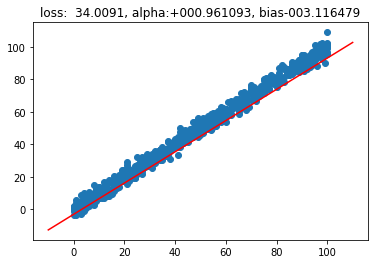

Generation  6 ____________________________________ 



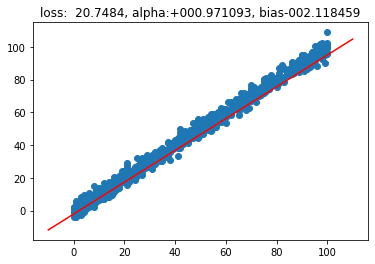

Generation  7 ____________________________________ 



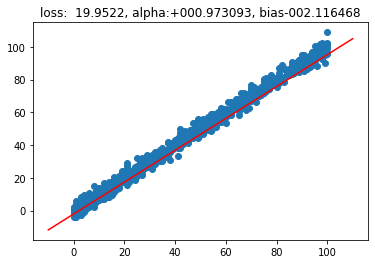

Generation  8 ____________________________________ 



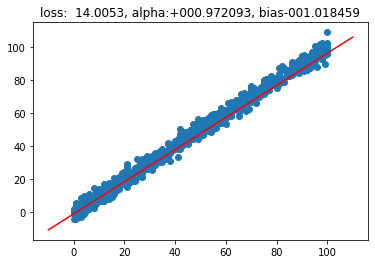

Generation  9 ____________________________________ 



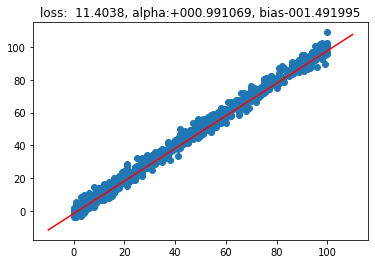

Generation 10 ____________________________________ 



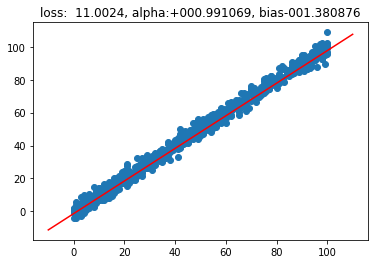

Generation 11 ____________________________________ 



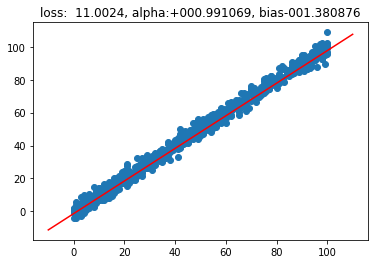

Generation 12 ____________________________________ 



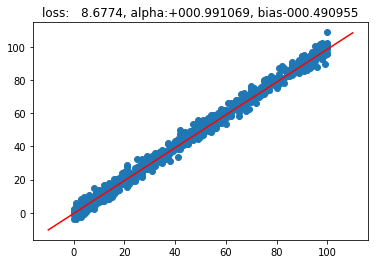

Generation 13 ____________________________________ 



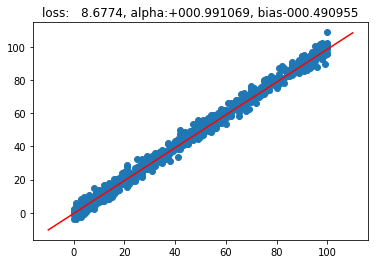

Generation 14 ____________________________________ 



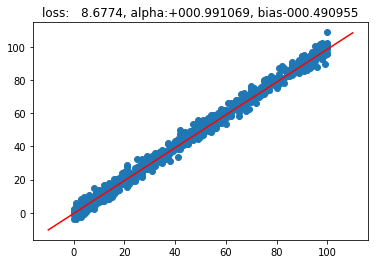

Generation 15 ____________________________________ 



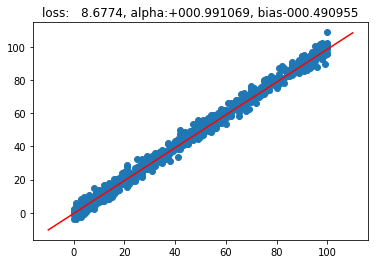

Generation 16 ____________________________________ 



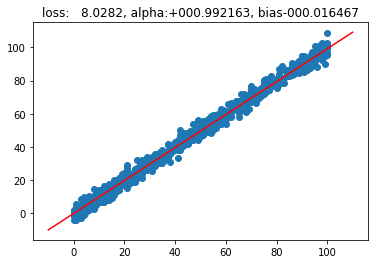

Generation 17 ____________________________________ 



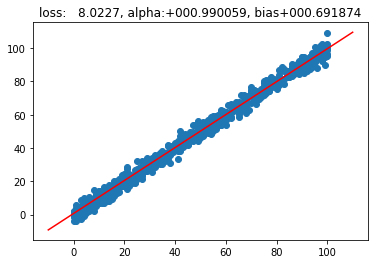

Generation 18 ____________________________________ 



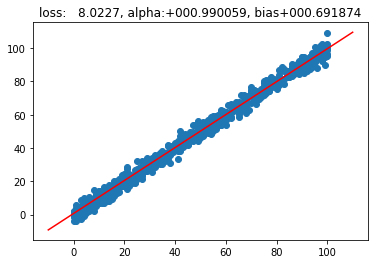

Generation 19 ____________________________________ 



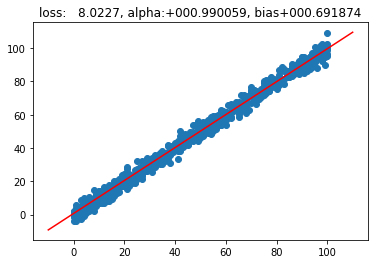

Generation 20 ____________________________________ 



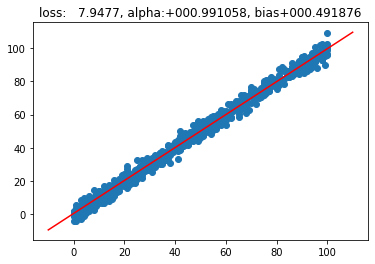

Generation 21 ____________________________________ 



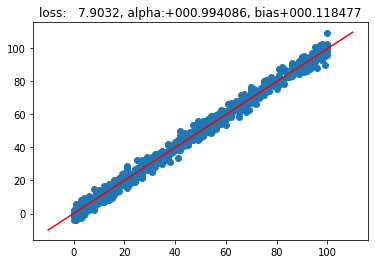

Generation 22 ____________________________________ 



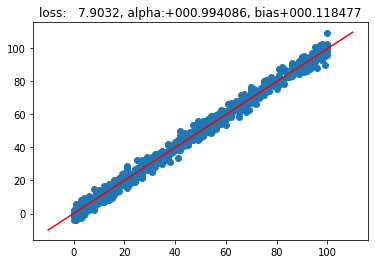

Generation 23 ____________________________________ 



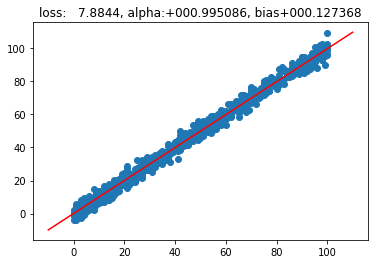

Generation 24 ____________________________________ 



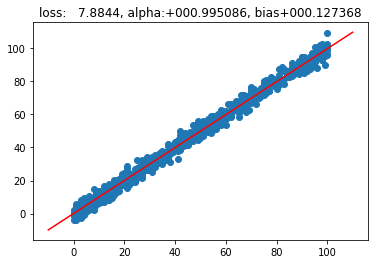

Generation 25 ____________________________________ 



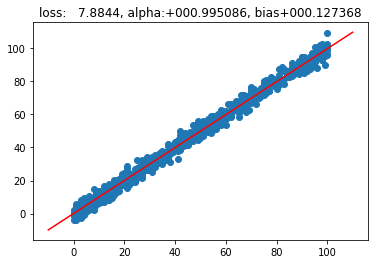

Generation 26 ____________________________________ 



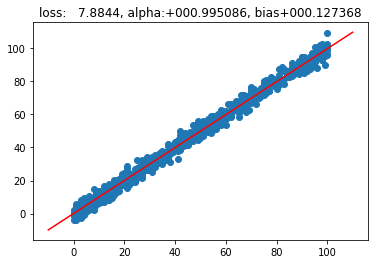

Generation 27 ____________________________________ 



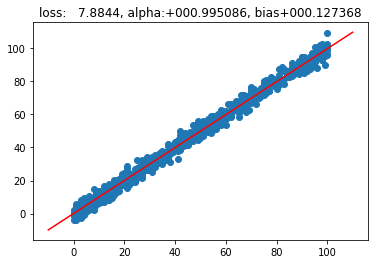

Generation 28 ____________________________________ 



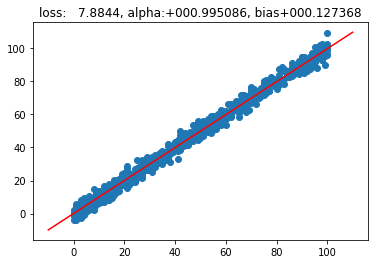

Generation 29 ____________________________________ 



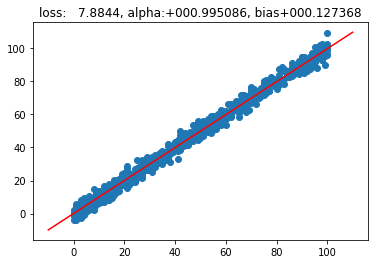

Generation 30 ____________________________________ 



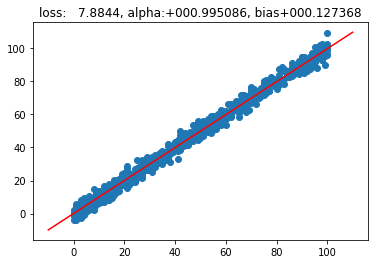

Generation 31 ____________________________________ 



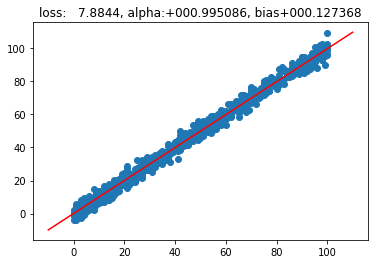

Generation 32 ____________________________________ 



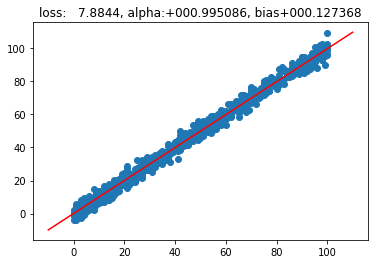

In [93]:
population = 2000
mutation_rate = 0.1
train = pd.read_csv(os.path.join('./input', 'train.csv'))
test = pd.read_csv(os.path.join('./input', 'test.csv'))
stop = 10
# https://www.kaggle.com/andonians/random-linear-regression

gr = GeneticRegression(population, mutation_rate, train, test, stop)
gr.fit()

> ## Genetic Regression #2
> Randomly created dataset for linear regression
> https://www.kaggle.com/andonians/random-linear-regression

In [ ]:
population = 2000
mutation_rate = 0.1
train = pd.read_csv(os.path.join('./input', 'train.csv'))
test = pd.read_csv(os.path.join('./input', 'test.csv'))
stop = 10
# https://www.kaggle.com/andonians/random-linear-regression

gr = GeneticRegression(population, mutation_rate, train, test, stop)
gr.fit()